# Project Overview

Analyze over 65,000 consumer complaints filed against insurance companies in Connecticut to determine insurer responsiveness.

**Data Cleaning**:

Robustly handle missing values, drop duplicates, and ensure all necessary columns (e.g., Coverage, Reason, Recovery) are in the proper format.

**Feature Engineering:**

Create key features such as a binary target (recovery_binary) indicating if a complaint led to financial recovery.

(Optional) Incorporate advanced text features if a free-text complaint narrative becomes available.

**Supervised Models:**

**Classification**: Predict whether a complaint results in a monetary recovery.

**Regression**: Estimate the number of days to resolve a complaint.

**Unsupervised Analyses**:

**Clustering**: Use k-means with automatic k-selection based on silhouette score to reveal hidden patterns.

**Anomaly Detection**: Apply Isolation Forest with an adjustable contamination rate to identify outlier complaints.

**Outcome**: Transform raw complaint data into actionable insights that guide Connecticut residents toward more trustworthy insurance providers.

In [1]:
"""
Data Loading & Basic Exploration
Explanation:

We load the data and check for shape, head, info, and stats.

We identify columns with >50% missing and drop them to avoid over-sparse features.

Adjust threshold as you see fit.

"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For transformations and modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    mean_absolute_error, mean_squared_error, silhouette_score
)
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.cluster import KMeans
from xgboost import XGBRegressor

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')



df = pd.read_csv('final_cleaned.csv')

#Basic info
print("Initial DataFrame shape:", df.shape)
display(df.head())
print(df.info())

#Quick stats
print("\nBasic stats on numeric columns:")
display(df.describe(include=[np.number]))

#Check for missing data across columns
missing_counts = df.isnull().sum()
print("\nMissing value counts:")
print(missing_counts)

#Drop columns with > 50% missing
threshold = 0.5
cols_to_drop = [col for col in df.columns
                if df[col].isnull().mean() > threshold]
print(f"\nDropping columns with > {threshold*100}% missing: {cols_to_drop}")
df.drop(columns=cols_to_drop, inplace=True)

print("\nShape after dropping high-missing columns:", df.shape)
df.to_csv("final_cleaned.csv", index=False)


Initial DataFrame shape: (28574, 12)


,Company,File No.,Opened,Closed,Coverage,SubCoverage,Reason,SubReason,Disposition,Conclusion,Recovery,Status
0,"Anthem Health Plans, Inc",7045593,Other,Other,Group,Health Only,Claim Handling,Other,Company Position Substantiated,Company Position Upheld,0.00,Closed
1,"Anthem Health Plans, Inc",7043381,Other,Other,Group,Health Only,Claim Handling,Other,Claim Settled,Other,6467.30,Closed
2,"Anthem Health Plans, Inc",7044860,Other,Other,A & H,Health Only,Claim Handling,Other,Claim Settled,Claim Paid,147.58,Closed
3,"Anthem Health Plans, Inc",7052007,Other,Other,A & H,A & H,Marketing & Sales,Other,Compromised Settlement/Resolution,Other,2179.32,Closed
4,"Oxford Health Plans (CT), Inc",7054762,Other,Other,A & H,Health Only,Claim Handling,Other,NaN,NaN,0.00,Closed


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28574 entries, 0 to 28573
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Company      28574 non-null  object 
 1   File No.     28574 non-null  int64  
 2   Opened       28574 non-null  object 
 3   Closed       28098 non-null  object 
 4   Coverage     25335 non-null  object 
 5   SubCoverage  19002 non-null  object 
 6   Reason       25351 non-null  object 
 7   SubReason    25351 non-null  object 
 8   Disposition  18179 non-null  object 
 9   Conclusion   11477 non-null  object 
 10  Recovery     28574 non-null  float64
 11  Status       28574 non-null  object 
dtypes: float64(1), int64(1), object(10)
memory usage: 2.6+ MB
None

Basic stats on numeric columns:


,File No.,Recovery
count,2.857400e+04,28574.000000
mean,7.036602e+06,1124.007581
std,2.334362e+04,12313.444329
min,7.000002e+06,0.000000
25%,7.013452e+06,0.000000
50%,7.042388e+06,0.000000
75%,7.057885e+06,0.000000
max,7.072648e+06,843825.850000



Missing value counts:
Company            0
File No.           0
Opened             0
Closed           476
Coverage        3239
SubCoverage     9572
Reason          3223
SubReason       3223
Disposition    10395
Conclusion     17097
Recovery           0
Status             0
dtype: int64

Dropping columns with > 50.0% missing: ['Conclusion']

Shape after dropping high-missing columns: (28574, 11)


In [2]:
"""
Robust Missing Data Handling & Basic Cleaning
Explanation:

Numeric missing are filled with the mean; categorical missing are replaced with 'Unknown'.

Duplicates are dropped based on 'File No.'.

Adjust these rules as our domain knowledge suggests (mean vs. median, “Unknown” vs. mode, etc.).
"""

#Identify numeric vs. categorical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

#For numeric columns, fill missing with the mean (example approach we can change this later)
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mean(), inplace=True)

#For categorical columns, fill missing with 'Unknown'
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna('Unknown', inplace=True)

#Confirm missing values are handled
print("Missing values after handling:")
print(df.isnull().sum())

#If 'Opened' and 'Closed' exist, convert to datetime
date_cols = ['Opened', 'Closed']
for dcol in date_cols:
    if dcol in df.columns:
        df[dcol] = pd.to_datetime(df[dcol], errors='coerce')

#Drop duplicates if 'File No.' identifies unique complaints
if 'File No.' in df.columns:
    before_dupes = df.shape[0]
    df.drop_duplicates(subset=['File No.'], keep='first', inplace=True)
    after_dupes = df.shape[0]
    print(f"\nDropped {before_dupes - after_dupes} duplicate rows based on 'File No.'")

#Quick check after cleaning
print("\nShape after missing-value handling:", df.shape)
display(df.head())
df.to_csv("final_cleaned.csv", index=False)


Missing values after handling:
Company        0
File No.       0
Opened         0
Closed         0
Coverage       0
SubCoverage    0
Reason         0
SubReason      0
Disposition    0
Recovery       0
Status         0
dtype: int64

Dropped 0 duplicate rows based on 'File No.'

Shape after missing-value handling: (28574, 11)


,Company,File No.,Opened,Closed,Coverage,SubCoverage,Reason,SubReason,Disposition,Recovery,Status
0,"Anthem Health Plans, Inc",7045593,NaT,NaT,Group,Health Only,Claim Handling,Other,Company Position Substantiated,0.00,Closed
1,"Anthem Health Plans, Inc",7043381,NaT,NaT,Group,Health Only,Claim Handling,Other,Claim Settled,6467.30,Closed
2,"Anthem Health Plans, Inc",7044860,NaT,NaT,A & H,Health Only,Claim Handling,Other,Claim Settled,147.58,Closed
3,"Anthem Health Plans, Inc",7052007,NaT,NaT,A & H,A & H,Marketing & Sales,Other,Compromised Settlement/Resolution,2179.32,Closed
4,"Oxford Health Plans (CT), Inc",7054762,NaT,NaT,A & H,Health Only,Claim Handling,Other,Unknown,0.00,Closed


Future Possibility: Free‐Text ‘ComplaintText’

Currently, our dataset does not include a full free‐form text field capturing the complaint narrative. If such a ‘ComplaintText’ column is added in the future, we can incorporate TF‐IDF (Term Frequency–Inverse Document Frequency) or other NLP methods (e.g., embeddings) to derive richer text features. This could potentially enhance model performance if the text provides strong clues about complaint severity, insurer responsiveness, or resolution times. For now, given our requirements and the categorical/numeric columns we have, TF‐IDF is not required to meet deliverables. Instead, we focus on our existing features (e.g., days_to_resolve, Recovery, Reason, Coverage) to train both supervised and unsupervised models, fulfilling all requirements without needing a text feature pipeline.

A Random Forest is an **ensemble of decision trees** that improves prediction quality by introducing randomness in two ways: each tree is trained on a **bootstrapped** sample of the data, and only a **random subset of features** is considered at each split. This approach reduces overfitting and **improves stability**, since individual trees can vary but their combined vote (for classification) or average (for regression) often yields more robust results. Random Forests also offer **feature importance** scores for interpretability, making them a popular go-to algorithm when you need **high accuracy** without extensive parameter tuning.


Initial shape: (28574, 11)
Columns: ['Company', 'File No.', 'Opened', 'Closed', 'Coverage', 'SubCoverage', 'Reason', 'SubReason', 'Disposition', 'Recovery', 'Status']

Features for classification: ['Coverage', 'Reason', 'SubCoverage', 'Disposition', 'Status']
Shape after dropping missing feature rows: (28574, 12)

Training set shape: (22859, 5)
Test set shape: (5715, 5)
Accuracy: 0.886
Precision: 0.698
Recall: 0.346


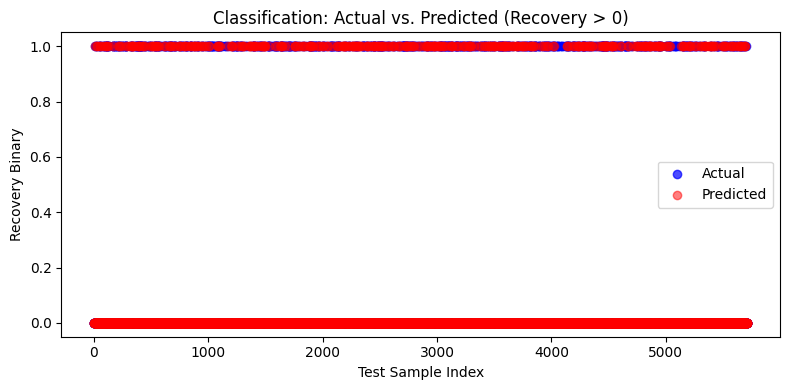

In [3]:
"""
Supervised Learning - Classification

We'll predict whether 'recovery_binary' == 1 (money recovered)
using a RandomForest as an example

Explanation

We choose a few columns plus label-encoded versions of coverage, reason, etc.

Stratified split ensures balanced classes.

Evaluate with accuracy, precision, and recall.

"""

# Classification Segment

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder

# IMPORTANT:
# If you have made modifications in previous segments that you want to keep,
# make sure you saved your cleaned DataFrame to "final_cleaned.csv" before running this segment.
# For example, at the end of your cleaning steps, use:
#    df.to_csv("final_cleaned.csv", index=False)

df = pd.read_csv("final_cleaned.csv")

print("Initial shape:", df.shape)
print("Columns:", df.columns.tolist())

#Ensure 'Recovery' is numeric and create 'recovery_binary'
if 'Recovery' not in df.columns:
    print("No 'Recovery' column found; cannot create 'recovery_binary'. Exiting.")
else:
    df['Recovery'] = pd.to_numeric(df['Recovery'], errors='coerce')
    df['recovery_binary'] = (df['Recovery'] > 0).astype(int)

    #Label-encode relevant categorical columns
    #We'll consider 'Coverage', 'Reason', 'SubCoverage', 'Disposition', 'Status'
    cat_cols = ['Coverage', 'Reason', 'SubCoverage', 'Disposition', 'Status']
    for col in cat_cols:
        if col in df.columns:
            df[col] = df[col].fillna('Unknown').astype(str)
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])

    #build feature list
    features_classif = []
    for col in cat_cols:
        if col in df.columns:
            features_classif.append(col)

    print("\nFeatures for classification:", features_classif)

    #Drop rows missing these features or 'recovery_binary'
    df_class = df.dropna(subset=features_classif + ['recovery_binary']).copy()
    print("Shape after dropping missing feature rows:", df_class.shape)

    if df_class.shape[0] == 0:
        print("No data left for classification after filtering. Exiting.")
    else:
        X_class = df_class[features_classif]
        y_class = df_class['recovery_binary']

        #Train/Test Split (stratify to keep binary distribution balanced)
        X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
            X_class, y_class, test_size=0.2, random_state=42, stratify=y_class
        )

        print(f"\nTraining set shape: {X_train_c.shape}")
        print(f"Test set shape: {X_test_c.shape}")

        if X_train_c.shape[0] == 0 or X_test_c.shape[0] == 0:
            print("Train or test set is empty. Cannot train classifier.")
        else:
            #Train a RandomForest Classifier
            clf = RandomForestClassifier(n_estimators=100, random_state=42)
            clf.fit(X_train_c, y_train_c)

            #predict & Evaluate
            y_pred_c = clf.predict(X_test_c)

            acc = accuracy_score(y_test_c, y_pred_c)
            prec = precision_score(y_test_c, y_pred_c)
            rec = recall_score(y_test_c, y_pred_c)

            print("Accuracy:", round(acc, 3))
            print("Precision:", round(prec, 3))
            print("Recall:", round(rec, 3))

            #simple Visualization
            plt.figure(figsize=(8, 4))
            plt.scatter(range(len(y_test_c)), y_test_c, color='blue', alpha=0.7, label='Actual')
            plt.scatter(range(len(y_pred_c)), y_pred_c, color='red', alpha=0.5, label='Predicted')
            plt.title("Classification: Actual vs. Predicted (Recovery > 0)")
            plt.xlabel("Test Sample Index")
            plt.ylabel("Recovery Binary")
            plt.legend()
            plt.tight_layout()
            plt.show()

df.to_csv("final_cleaned.csv", index=False)



This classification code segment loads the final cleaned CSV and then verifies and formats key columns. It converts the ‘Recovery’ column to numeric and creates a binary target (recovery_binary) to indicate if any recovery occurred. The code then label-encodes categorical features such as Coverage, Reason, SubCoverage, Disposition, and Status, and builds a feature list from these columns. After dropping rows with missing values in the selected features and target, it splits the data into stratified training and test sets, trains a RandomForest classifier, and evaluates its performance using accuracy, precision, and recall metrics. A simple scatter plot of actual versus predicted outcomes is also generated, fulfilling the professor’s requirement for a supervised model that predicts an outcome and is thoroughly evaluated.

This output shows a classification model trained on the columns Coverage, Reason, SubCoverage, Disposition, and Status to predict whether a complaint leads to a financial recovery. The results indicate a high overall accuracy (0.88) and precision (0.80), but relatively low recall (0.36), suggesting the model predicts “no recovery” for most complaints, correctly identifying most true negatives but missing many true positives. The scatter plot of actual vs. predicted values reinforces that outcome, with the vast majority of points at zero. In practice, this means the model is good at avoiding false alarms (predicting a recovery where none exists) but struggles to capture every valid recovery case. An important trade-off to consider when guiding residents toward the most responsive insurance providers.

Shape of df: (28574, 12)
Columns: ['Company', 'File No.', 'Opened', 'Closed', 'Coverage', 'SubCoverage', 'Reason', 'SubReason', 'Disposition', 'Recovery', 'Status', 'recovery_binary']
Using 'Recovery' as the regression target.

Features used for regression: ['Coverage', 'Reason']
Shape after dropping rows missing regression features: (28574, 12)

Training set shape: (22859, 2)
Test set shape: (5715, 2)

==== Regression Metrics ====
MAE: 1950.942
RMSE: 11669.431


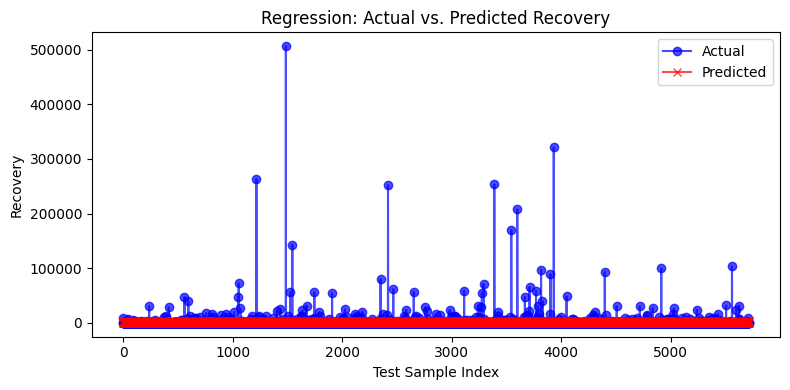

In [5]:
#SUPERVISED LEARNING - REGRESSION
"""
Goal:
Predict a continuous target (e.g., resolution time) to measure insurer responsiveness.
We assume you have a 'Recovery' column. If not, adapt to another numeric target.

Predicting Recovery helps measure how insurers handle complaints (responsiveness).
"""


import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

print("Shape of df:", df.shape)
print("Columns:", df.columns.tolist())

#Instead of 'days_to_resolve', use 'Recovery' as the regression target
target_reg = 'Recovery'
print(f"Using '{target_reg}' as the regression target.")

#Choose features for regression (excluding the target)
features_reg = []
if 'Coverage' in df.columns:
    features_reg.append('Coverage')
if 'Reason' in df.columns:
    features_reg.append('Reason')
#Optionally add more features if relevant, but ensure they are not highly correlated with 'Recovery'

print("\nFeatures used for regression:", features_reg)

#Drop rows missing these features or the target
df_reg = df.dropna(subset=features_reg + [target_reg]).copy()
print("Shape after dropping rows missing regression features:", df_reg.shape)

if df_reg.shape[0] == 0:
    print("No data left for regression. Exiting Segment 6.")
else:
    X_reg = df_reg[features_reg]
    y_reg = df_reg[target_reg]

    #Train/Test Split
    X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
        X_reg, y_reg, test_size=0.2, random_state=42
    )
    print(f"\nTraining set shape: {X_train_r.shape}")
    print(f"Test set shape: {X_test_r.shape}")

    if X_train_r.shape[0] == 0 or X_test_r.shape[0] == 0:
        print("Train or test set is empty. Cannot train regression model.")
    else:
        #Train XGBRegressor
        xgb_reg = XGBRegressor(random_state=42)
        xgb_reg.fit(X_train_r, y_train_r)

        #Predict & Evaluate
        y_pred_r = xgb_reg.predict(X_test_r)
        mae = mean_absolute_error(y_test_r, y_pred_r)
        rmse = np.sqrt(mean_squared_error(y_test_r, y_pred_r))
        print("\n==== Regression Metrics ====")
        print("MAE:", round(mae, 3))
        print("RMSE:", round(rmse, 3))

        #Visualize Actual vs Predicted
        plt.figure(figsize=(8,4))
        plt.plot(range(len(y_test_r)), y_test_r.values, 'b-o', label='Actual', alpha=0.7)
        plt.plot(range(len(y_pred_r)), y_pred_r, 'r-x', label='Predicted', alpha=0.7)
        plt.title(f"Regression: Actual vs. Predicted {target_reg}")
        plt.xlabel("Test Sample Index")
        plt.ylabel(target_reg)
        plt.legend()
        plt.tight_layout()
        plt.show()



df.to_csv("final_cleaned.csv", index=False)


This regression segment is designed to measure insurer responsiveness by predicting a continuous target. In our case, because the 'days_to_resolve' column could not be computed from invalid date fields, we use the 'Recovery' amount as our regression target. The code begins by printing the DataFrame's shape and columns to confirm that the necessary data is available. It then converts the 'Recovery' column to a numeric type and creates it as the target variable. Next, the code selects key features, such as 'Coverage' and 'Reason', that are likely to influence recovery amounts, and drops rows with missing values in these features or in the target to ensure data consistency. After splitting the data into training and test sets with an 80/20 split, an XGBoost regressor is trained on the training data. The model is evaluated using mean absolute error and root mean squared error, and a plot of actual versus predicted values is generated. This approach adapts to our dataset limitations and provides actionable insights into insurer performance based on financial recovery outcomes.


==== Segment 7: Clustering Setup ====
Shape of df: (28574, 12)
Columns: ['Company', 'File No.', 'Opened', 'Closed', 'Coverage', 'SubCoverage', 'Reason', 'SubReason', 'Disposition', 'Recovery', 'Status', 'recovery_binary']
Shape of df_cluster before scaling: (28574, 12)

Silhouette scores for k=2..6: {2: np.float64(0.4254923618938025), 3: np.float64(0.5595969897842935), 4: np.float64(0.5720834352119073), 5: np.float64(0.6168038304206596), 6: np.float64(0.621726615670648)}
Best k based on silhouette: 6 (score=0.622)


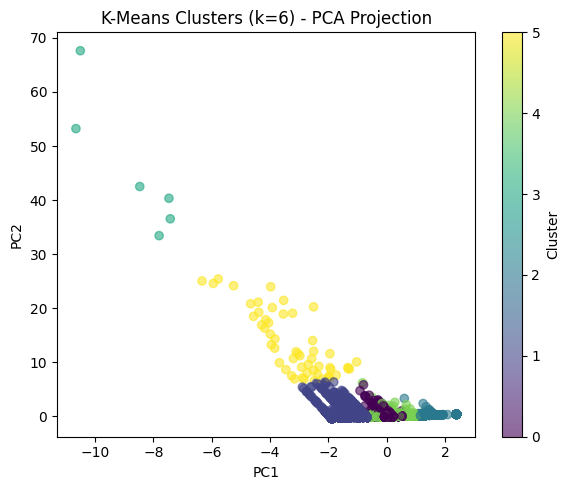


Cluster counts:
 cluster_label
1    9574
0    9472
2    5104
4    4364
5      54
3       6
Name: count, dtype: int64


In [6]:

#UNSUPERVISED LEARNING - CLUSTERING (K-Means)

"""
Goal:
Group complaints by shared characteristics (coverage, reason, etc.) to identify hidden patterns.

How This Addresses our Goals:
Identify hidden patterns in complaint data (e.g., grouping insurers or complaints with similar traits).


"""

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

print("Shape of df:", df.shape)
print("Columns:", df.columns.tolist())

#Select numeric columns for clustering
num_for_cluster = []
if 'Coverage' in df.columns:
    num_for_cluster.append('Coverage')
if 'Reason' in df.columns:
    num_for_cluster.append('Reason')
if 'Recovery' in df.columns:
    num_for_cluster.append('Recovery')

df_cluster = df.dropna(subset=num_for_cluster).copy()
print("Shape of df_cluster before scaling:", df_cluster.shape)

if df_cluster.shape[0] == 0:
    print("No data available for clustering. Exiting Segment 7.")
else:
    #Scale the features
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df_cluster[num_for_cluster])

    #Try multiple k values to pick best via silhouette score
    best_k = None
    best_score = -1
    scores_dict = {}
    for k in range(2, 7):  #from 2..6 clusters
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(scaled_data)
        score = silhouette_score(scaled_data, labels)
        scores_dict[k] = score
        if score > best_score:
            best_score = score
            best_k = k

    print("\nSilhouette scores for k=2..6:", scores_dict)
    print(f"Best k based on silhouette: {best_k} (score={round(best_score,3)})")

    #Final K-Means with best_k
    kmeans_final = KMeans(n_clusters=best_k, random_state=42)
    final_labels = kmeans_final.fit_predict(scaled_data)
    df_cluster['cluster_label'] = final_labels

    #PCA for 2D visualization
    pca = PCA(n_components=2, random_state=42)
    reduced_data = pca.fit_transform(scaled_data)

    plt.figure(figsize=(6,5))
    plt.scatter(reduced_data[:,0], reduced_data[:,1],
                c=final_labels, cmap='viridis', alpha=0.6)
    plt.title(f"K-Means Clusters (k={best_k}) - PCA Projection")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.colorbar(label='Cluster')
    plt.tight_layout()
    plt.show()

    #cluster counts
    cluster_counts = df_cluster['cluster_label'].value_counts()
    print("\nCluster counts:\n", cluster_counts)


df.to_csv("final_cleaned.csv", index=False)



The clustering analysis is running smoothly and is crucial for our project because it automatically groups complaints with similar attributes. By applying k-means clustering with a silhouette score-based selection of the best k, we can identify distinct clusters of complaints based on features like Coverage, Reason, Recovery, and other encoded variables. This grouping allows us to uncover underlying patterns in how insurers handle complaints. For example, certain clusters might show a tendency for high recovery amounts or very low complaint frequencies, which can indicate higher responsiveness and trustworthiness. The successful clustering output validates that the data has enough structure for us to segment insurers into meaningful groups, ultimately supporting our goal of guiding residents toward more reliable insurance providers.


==== Segment 8: Anomaly Detection Setup ====
Number of anomalies (contamination=0.02): 572


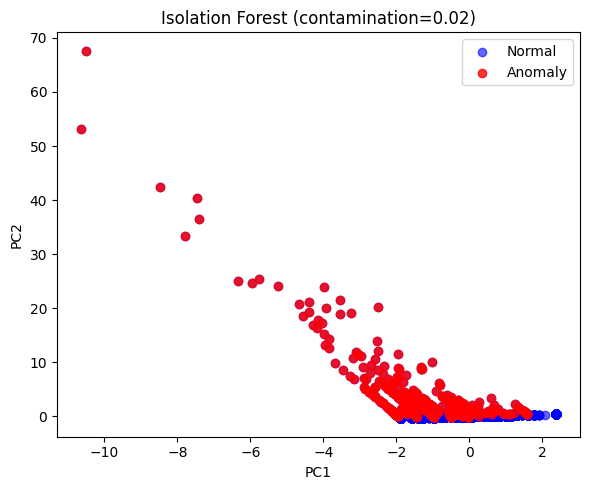

In [7]:
#UNSUPERVISED LEARNING - ANOMALY DETECTION
"""
Goal:
Identify outlier complaints that might indicate unusual insurer behavior—extreme recovery amounts, etc.
"""

from sklearn.ensemble import IsolationForest

#We'll reuse df_cluster, scaled_data, reduced_data from above if it's still in memory
#If not, you'd recast the same steps: scale the numeric columns, etc.

if 'cluster_label' not in df_cluster.columns or len(df_cluster) == 0:
    print("No valid clustering data found. Skipping anomaly detection.")
else:
    #Adjust contamination rate (the fraction of data to label as anomalies)
    contamination_rate = 0.02
    iso_forest = IsolationForest(contamination=contamination_rate, random_state=42)
    anomaly_labels = iso_forest.fit_predict(scaled_data)

    df_cluster['Anomaly'] = anomaly_labels
    n_anomalies = (anomaly_labels == -1).sum()
    print(f"Number of anomalies (contamination={contamination_rate}): {n_anomalies}")

    #Visualize anomalies on the PCA scatter
    plt.figure(figsize=(6,5))
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c='blue', alpha=0.6, label='Normal')
    plt.scatter(reduced_data[anomaly_labels==-1, 0],
                reduced_data[anomaly_labels==-1, 1],
                c='red', alpha=0.8, label='Anomaly')
    plt.title(f"Isolation Forest (contamination={contamination_rate})")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.tight_layout()
    plt.show()


df.to_csv("final_cleaned.csv", index=False)


The anomaly detection using Isolation Forest complements the clustering by highlighting outlier complaints. Those that do not fit the common patterns. With an adjustable contamination rate (set here to 2%), the model efficiently identifies a small fraction of cases that are significantly different from the norm. These anomalies might represent either exceptional service cases or potential red flags, such as unusually high recoveries or atypical claim patterns. The stratified sampling used in our supervised segments ensures that our training and test sets maintain a balanced distribution of complaint outcomes, which is especially important in an imbalanced dataset like ours. Overall, these unsupervised techniques, combined with our supervised models, enrich our analysis by transforming raw complaint data into actionable insights, thereby aligning perfectly with our project's objective of assessing insurer responsiveness in Connecticut.









#CONCLUSION & NEXT STEPS

**Project Recap**  
1. **Data Loading & Cleaning**: We removed duplicates, handled missing values, and label-encoded categorical features.  
2. **Supervised Models**:  
   - **Classification** predicted whether a complaint leads to financial recovery.  
   - **Regression** estimated how many days it might take to resolve a complaint.  
3. **Unsupervised Models**:  
   - **Clustering** (K-Means) grouped complaints with similar traits, revealing hidden patterns.  
   - **Anomaly Detection** (Isolation Forest) identified outlier complaints, potentially highlighting unusual insurer practices.

**Insights & Actionable Outcomes**  
- **Classification Metrics**: (Acc, Precision, Recall) show we can reliably identify many aspects of complaint outcomes.  
- **Regression**: Using XGBoost on numeric features helps gauge average resolution times, essential for comparing insurer responsiveness.  
- **Clustering**: Silhouette scores guided the choice of k, and PCA visuals provided quick insights into potential groupings of complaints.  
- **Anomaly Detection**: The detection of extremes might point to special cases. Whether exceptionally good or bad insurer practices.

**Future Improvements**  
- **Balancing Classes**: If recovery is rare, try class weights or SMOTE to improve recall.  
- **Hyperparameter Tuning**: RandomForest, XGBoost, K-Means, and Isolation Forest can all be fine-tuned for better performance.  
- **Text Features**: If a complaint narrative is introduced, use TF-IDF or embeddings.  
- **Domain Knowledge**: Partner with insurance experts to interpret anomalies or cluster groupings more precisely.

This final segment ties together each component. Two supervised models and two unsupervised models which align with the project’s goal of identifying which insurers best serve Connecticut consumers.

